In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import math
import numpy as np

In [2]:
# parameters for group effect
g1 = 2
g2 = 2
g3 = 0.5

# model parameters
sigma = 0.5
beta = 1

In [3]:
'''
To account for observations on the number of people choosing each choice,
we introduce an observations array that we can dynamically change during 
simulations to model the fraction of people at each choice. We then add
an additional factor when obtaining decision values from probability 
distributions to account for a group effect in exploration vs exploitation.
The current function to obtain the group weight factor from the group 
fraction t is of the form at^b + c. Moving forward, we will look at more
complex functions, tune parameters, and consider other ways to represent
observed choices of others in the exploration exploitation process.
'''

def decision_vals(t, weight):
    x = t[0]
    expected = x[0]/(x[0] + x[1])
    uncertainty_bonus = sigma * (x[0] * x[1])/((x[0] + x[1])**2 * (x[0] + x[1] + 1))
    social_bonus = g1*t[1]**g2 + g3
    return (expected + uncertainty_bonus + social_bonus * weight)
  
def social_weight(entropy, max_entropy, population, max_population):
    '''
    use entropy as a measure of personal accuracy: social bonus decreases with entropy 
    use number of other ppl (rel to recent #) as measure of societal accuracy?
    use number of times you agreed with most common choice as comparison of your utility with the population's?
    '''
    return (entropy/max_entropy) * (population/max_population) 
    
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def prob_index(probs):
    r = random.random()
    index = 0
    while(r >= 0 and index < len(probs)):
        r -= probs[index]
        index += 1
    return index - 1

def get_entropy(prob_arr):    
    arr = list(map((lambda x : x * math.log(x)), prob_arr))
    return -1 * sum(arr)

# arbitrary reward probabilities
rewards = [0.1, 0.3, 0.5, 0.7, 0.9]
# observed number of people currently choosing each option
observations = [2.0, 3.0, 1.0, 4.0, 0.0]

# initialize distribution params to all be (alpha, beta) = (1, 1)
dist_params = [[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0]]

counts = [0, 0, 0, 0, 0]
entropy_arr = []
population_arr = []

for i in range(200):
    entropy = get_entropy(map(lambda x: x[0]/(x[0] + x[1]), dist_params))
    entropy_arr.append(entropy)
    
    num_obs = sum(observations)
    population_arr.append(num_obs)
    
    obs_percentage = map(lambda x: x/num_obs, observations)
    weight = social_weight(entropy, max(entropy_arr), num_obs, max(population_arr[-7:]))
    value_arr = [decision_vals(t, weight) for t in zip(dist_params, obs_percentage)]    #list(map(decision_vals, zip(dist_params, observations)))
    prob_arr = softmax(value_arr)
    chosen_index = prob_index(prob_arr)
    counts[chosen_index] += 1
    
    # give reward based on chosen option's probability, update values based on reward
    reward = random.random()
    if reward < rewards[chosen_index]:
        dist_params[chosen_index][0] += 1
    else:
        dist_params[chosen_index][1] += 1

print counts
print dist_params

[23, 28, 32, 68, 49]
[[6.0, 19.0], [7.0, 23.0], [16.0, 18.0], [49.0, 21.0], [40.0, 11.0]]


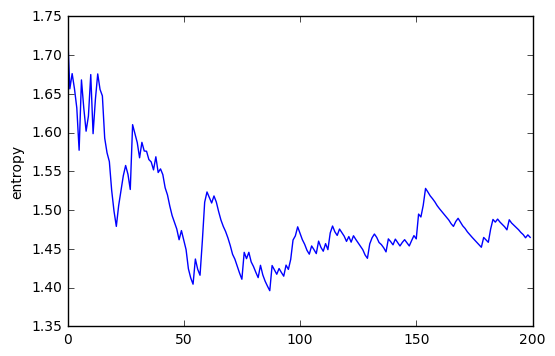

In [4]:
plt.plot(entropy_arr)
plt.ylabel('entropy')
plt.show()